In [2]:
current_path = %pwd
print current_path

D:\ipythonnotebook


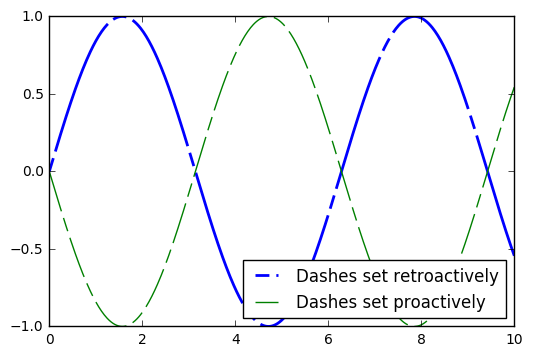

In [23]:
"""
Demo of a simple plot with a custom dashed line.

A Line object's ``set_dashes`` method allows you to specify dashes with
a series of on/off lengths (in points).
"""
import numpy as np
import matplotlib.pyplot as plt


x = np.linspace(0, 10, 500)
dashes = [10, 5, 100, 5]  # 10 points on, 5 off, 100 on, 5 off

fig, ax = plt.subplots()
line1, = ax.plot(x, np.sin(x), '--', linewidth=2,
                 label='Dashes set retroactively')
line1.set_dashes(dashes)

line2, = ax.plot(x, -1 * np.sin(x), dashes=[30, 5, 10, 5],
                 label='Dashes set proactively')

ax.legend(loc='lower right')
plt.show()

0.0100580580581


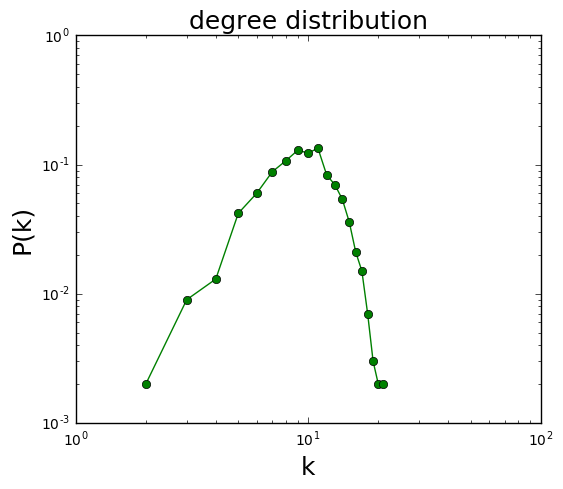

In [26]:
import random
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import json

def graph_rewiring(G, p):
    """Return a temporal Watts–Strogatz small-world graph.

    Parameters
    ----------
    G : input graph
    p : float
        The probability of rewiring each edge
    """
    # rewire edges from each node
    # loop over all nodes in order (label) and neighbors in order (distance)
    # no self loops or multiple edges allowed
    edge = nx.to_edgelist(G)  # generate edges list
    n = len(G)  # amount of nodes
    nodes = list(range(n))  # generate nodes list
    for i in range(len(edge)):
        if random.random() < p:
            w = random.choice(nodes)
            # Enforce no self-loops or multiple edges
            while w == edge[i][0] or G.has_edge(edge[i][0], w):
                w = random.choice(nodes)
                if G.degree(edge[i][0]) >= n - 1:
                    break
            else:
                G.remove_edge(edge[i][0], edge[i][1])
                G.add_edge(edge[i][0], w)
    return G


def connected_graph_rewiring(G, p, tries=2000):
    """Returns a connected temporal Watts–Strogatz small-world graph.

    Parameters
    ----------
    G : input graph
    p : float
        The probability of rewiring each edge
    tries : int
        Number of attempts to generate a connected graph.
    """
    G = graph_rewiring(G, p)
    t = 1
    while not nx.is_connected(G):
        G = graph_rewiring(G, p)
        t += 1
        if t > tries:
            raise nx.NetworkXError("Maximum number of tries exceeded")
    return G

kn_G = nx.random_graphs.fast_gnp_random_graph(1000, 0.01)
net_initial = nx.to_dict_of_dicts(kn_G)
fig = plt.figure(figsize=(6,5))
ax = plt.subplot(111)
p = 0.1

tNet = {}
tG = kn_G
tNet[1] = net_initial
for ti in range(1, 6):
    tG = connected_graph_rewiring(tG, p)
    tempNet = nx.to_dict_of_dicts(tG)
    # print len(tempNet)
    tNet[ti] = tempNet
    
for i in range(1,2):
    graph = nx.Graph(tNet[i])
    print nx.density(graph)
    degree = nx.degree_histogram(graph)
    x = range(len(degree))
    y = [z/float(sum(degree)) for z in degree]

    plt.loglog(x,y,'g-o')
    

ax.set_xlabel("k",fontsize=18)
ax.set_ylabel("P(k)",fontsize=18)
ax.set_title("degree distribution",fontsize=18)
#     nx.draw(tempNet,pos=nx.random_layout(tempNet))

# figpath = "F:\\FIG\\ER_digreedistributiob.png"
# plt.savefig(figpath, dpi=320)
plt.show()

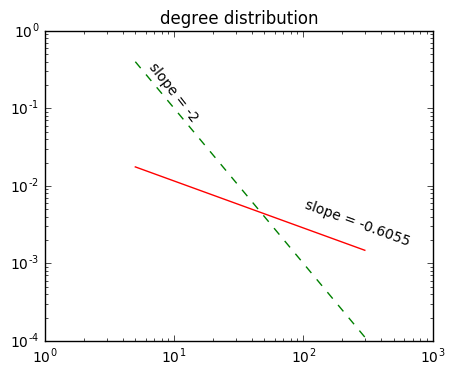

In [62]:
import numpy as np
import math
import matplotlib.pyplot as plt
a = 0.04657
a2 = 10
b = -0.6055
c = -2
x = range(5,300)
y = [a*xi**b for xi in x] 
y2 = [a2*xi**c for xi in x] 
fig = plt.figure(figsize=(5,4))
ax = plt.subplot(111)

line1, = ax.loglog(x,y,'r-')
line2, = ax.loglog(x,y2,'g--')
ax.text(100,0.005,"slope = %s"%b, rotation = 340)
ax.text(6,0.3,"slope = %s"%c, rotation = 308)
# ax.set_xticks(np.arange(1,10001,1))
ax.set_title("degree distribution")
plt.show()

0.00320920920921


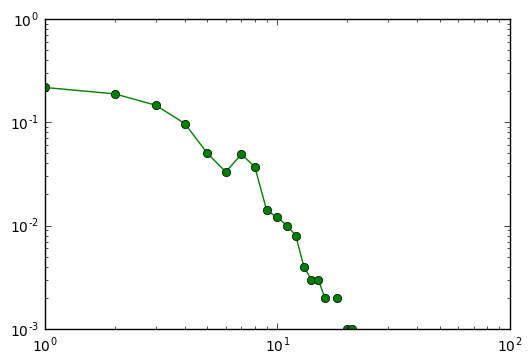

In [316]:
# -*- coding: utf-8 -*-
import random
import networkx as nx
import matplotlib.pyplot as plt

# Inverse Transform Method
# more efficient
def powerlaw_num(v, xmin=0.02):
    x = random.uniform(0, 1./(1+v)*xmin**(-1-v))
    return (xmin**(-1-v)-(1+v)*x)**(-1./(1+v))

# Generating an empty graph
def emptyGraph(N):
    G = nx.Graph()
    G.add_nodes_from(range(N))
    return G

# Generating activity driven time-varying network in one timeslot
def init_activityDriven(N=1000, m=6):
    """"
    Parameters
    ----------
    N :   nodes
    m :   rewiring links
    """
    # initiate parameters
    # N = 1000   # nodes
    # m = 6     # rewiring links
    dt = 1    # active slot
    eta = 10  # rescaling factor , ai = eta * xi

    G = nx.Graph()
    G.add_nodes_from(range(N))
    for i in range(N):
        xi = powerlaw_num(3, 0.03)  # node's activated prob belongs to F(x)=x**(-3)
        if random.random() <= eta * xi * dt:
            for mi in range(m):
                j = random.choice(range(N))
                while j == i or G.has_edge(i, j):
                    j = random.choice(range(N))
                G.add_edge(i, j)
    return G  # return a graph object

# Generating T time steps time-varying activity driven networks
def temporal_activityDriven(N=1000, m=6, T=5):
    """"
    Parameters
    ----------
    N :   nodes
    m :   rewiring links
    T :   time slots
    """
    tG = {}
    for i in range(1, T+1):
        G_temp = init_activityDriven(N, m)
        tempNet = nx.to_dict_of_dicts(G_temp)
        tG[i] = tempNet
    return tG  # return a dict-like time-varying graph


def temporal_activityDriven_withMemory(N=1000, m=6, T=5, r=0):
    """"
    Parameters
    ----------
    N :   nodes
    m :   rewiring links
    T :   time slots
    r :   memory rate, keeping previous links
    """
    # initiate parameters
    # N = 100   # nodes
    # T = 1000  # time slots
    # r = 0.1   # memory rate, keeping previous links
    dt = 1    # active slot
    eta = 10  # rescaling factor , ai = eta * xi

    G0 = init_activityDriven(N, m)  # initial graph
    G1 = G0   # current timeslot graph
    tG = {1: nx.to_dict_of_dicts(G0)}  # graph dicts
    for ti in range(2, T+1):
        G2 = G1  # previous timeslot graph
        G1 = emptyGraph(N)  # current timeslot graph
        for i in range(N):
            xi = powerlaw_num(3, 0.03)  # node's activated prob belongs to F(x)=x**(-3)
#             print xi*eta
            if random.random() < eta * xi * dt:  # node i is active
#                 ki = nx.degree(G2, i)            # calculate degree of node i
                neighbors = G2.neighbors(i)      # neighbors list of node i
                # link selection of each neighbor
                if len(neighbors) > 0:
                    for neighbor in neighbors:
                        if random.random() < r:
                            # randomly keep one previous neighbor
                            j = neighbor
                            G1.add_edge(i, j)
                        else:
                            # randomly select one other node
                            # G1.remove_edge(i,neighbor)
                            j = random.choice(list(set(range(N)) - {i} - set(neighbors)))
                            count = 0
                            while G1.has_edge(i, j):
                                j = random.choice(list(set(range(N)) - {i} - set(neighbors)))
                                count += 1
                            G1.add_edge(i, j)
                else:
                    for mi in range(m):
                        j = random.choice(range(N))
                        while j == i or G1.has_edge(i, j):
                            j = random.choice(range(N))
                        G1.add_edge(i, j)
                    
        tempNet = nx.to_dict_of_dicts(G1)
        tG[ti] = tempNet
    return tG  # return a dict-like time-varying graph


tG = temporal_activityDriven_withMemory(1000,6,10,0.1)
# tG = temporal_activityDriven(1000, 6, 6)

for i in range(5,6):
    graph = nx.Graph(tG[i])
    print nx.density(graph)
    degree = nx.degree_histogram(graph)
    x = range(len(degree))
    y = [z/float(sum(degree)) for z in degree]

    plt.loglog(x,y,'g-o')
#     nx.draw(tempNet,pos=nx.random_layout(tempNet))
plt.show()

# for i in range(1,21):
#     tempNet = nx.Graph(tG[i])
#     print nx.density(tempNet)
#     nx.draw(tempNet,pos=nx.random_layout(tempNet))
#     plt.show()    

# Calculating AD Time Varying Network Correlation / Evolution Rate

network_1 has 4788 links
network_1 has 4740 links
network_1 has 4596 links
network_1 has 4572 links
network_1 has 4428 links
network_1 has 4812 links
network_1 has 4680 links
network_1 has 4824 links
network_1 has 4884 links
network_1 has 4836 links
network_1 has 4428 links
[0.0, 0.07796947441123588, 0.1527132509053944, 0.22419383670167187, 0.29173721610341546, 0.35860243717042584, 0.41982272180435376, 0.4787993315317711, 0.5339767523762681, 0.5865883343703486, 0.6377163560887983]


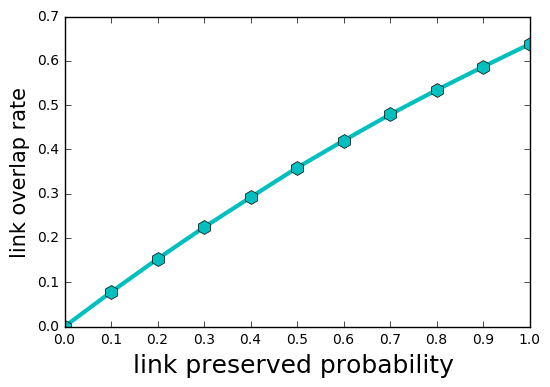

In [33]:
import json
import numpy as np
import matplotlib.pyplot as plt

N = 1000
m = 6
T = 1000
# p = 0.1

evoulitonRate = []
for p in np.arange(0.0,1.1,0.1):
    networkPath = "F:\\ActivityDrivenNetwork\\ADM_N_%s_m_%s_T_%s_p_%s.json"%(N, m, T, p)
    tNet = json.load(open(networkPath))

    Net1 = tNet[str(1)]
    link1 = []
    for n, neighbors in Net1.iteritems(): 
        for u in neighbors:
            link1.append("%s_%s"%(n,u))
    print "network_1 has %s links"%(len(set(link1)))

    commonRatio = []
    lastLink = link1
    for i in range(2,1001):
        tempNet = tNet[str(i)]
        templink = []
        for n, neighbors in tempNet.iteritems(): 
            for u in neighbors:
                templink.append("%s_%s"%(n,u))
        tempRatio = len(set(lastLink) & set(templink))/(len(lastLink)*len(templink))**0.5
#         tempRatio = len(set(lastLink) & set(templink))/float(len(set(lastLink) | set(templink)))
        commonRatio.append(tempRatio)
        lastLink = templink
    evoulitonRate.append(sum(commonRatio)/len(commonRatio))
        
print evoulitonRate                
fig = plt.figure(figsize=(6,4))
ax = plt.subplot(111)
ax.plot(np.arange(0.0,1.1,0.1),evoulitonRate,'c-h',linewidth=3,markersize=10)

# ax.set_xlabel("p",fontsize=18)
# ax.set_ylabel("network evolution rate",fontsize=15)
ax.set_xlabel("link preserved probability ",fontsize=18)
ax.set_ylabel("link overlap rate",fontsize=15)
ax.set_xticks(np.arange(0.0,1.01,0.1))

# save fig
figpath = "F:\\FIG\\AD_Evolution_with_p.png"
plt.savefig(figpath)

plt.show()

# Calculating ER Time Varying Network Correlation / Evolution Rate

network_1 has 1044 links
network_1 has 1044 links
network_1 has 1044 links
network_1 has 1044 links
network_1 has 1044 links
network_1 has 1044 links
network_1 has 1044 links
network_1 has 1044 links
network_1 has 1044 links
network_1 has 1044 links
network_1 has 1044 links
[1.0, 0.8999593463194991, 0.8017883784167309, 0.7058284337977816, 0.6177921216235402, 0.5425828126977565, 0.4803098117274361, 0.4305550761489455, 0.39119962874752123, 0.36063458094109396, 0.33472553012782874]


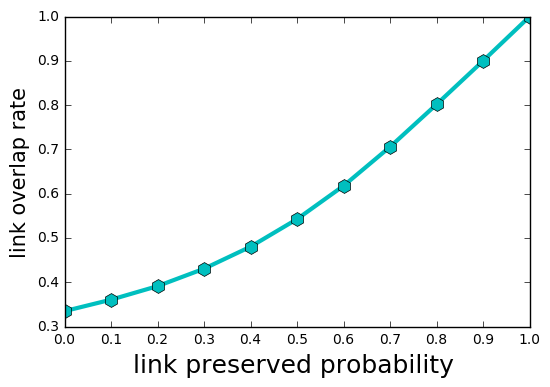

In [35]:
import json
import numpy as np

N = 1000
m = 10
T = 1000
# p = 0.1

evoulitonRate = []
for p in np.arange(0.0,1.1,0.1):
    networkPath = "F:\\ERNetwork\\ER_N_%s_m_%s_T_%s_p_%s.json"%(N, m, T, p)
    tNet = json.load(open(networkPath))

    Net1 = tNet[str(1)]
    link1 = []
    for n, neighbors in Net1.iteritems(): 
        for u in neighbors:
            link1.append("%s_%s"%(n,u))
    print "network_1 has %s links"%(len(set(link1)))

    commonRatio = []
    lastLink = link1
    for i in range(2,1001):
        tempNet = tNet[str(i)]
        templink = []
        for n, neighbors in tempNet.iteritems(): 
            for u in neighbors:
                templink.append("%s_%s"%(n,u))
        tempRatio = len(set(lastLink) & set(templink))/(len(lastLink)*len(templink))**0.5
#         tempRatio = len(set(lastLink) & set(templink))/float(len(set(lastLink) | set(templink)))
        commonRatio.append(tempRatio)
        lastLink = templink
    evoulitonRate.append(sum(commonRatio)/len(commonRatio))
print evoulitonRate
                
fig = plt.figure(figsize=(6,4))
ax = plt.subplot(111)
ax.plot(np.arange(0.0,1.1,0.1),evoulitonRate[::-1],'c-h',linewidth=3,markersize=10)

ax.set_xlabel("link preserved probability ",fontsize=18)
# ax.set_ylabel("network evolution rate",fontsize=15)
ax.set_ylabel("link overlap rate",fontsize=15)
ax.set_xticks(np.arange(0.0,1.01,0.1))

# save fig
# figpath = "F:\\FIG\\ER_Evolution_with_p.png"
# plt.savefig(figpath)

plt.show()

In [4]:
print'\n'.join([''.join([('AndyLove'[(x-y)%8]if((x*0.05)**2+(y*0.1)**2-1)**3-(x*0.05)**2*(y*0.1)**3<=0 else' ')for x in range(-30,30)])for y in range(15,-15,-1)])

                                                            
                                                            
                                                            
                veAndyLov           dyLoveAnd               
            yLoveAndyLoveAndy   eAndyLoveAndyLove           
          dyLoveAndyLoveAndyLoveAndyLoveAndyLoveAnd         
         dyLoveAndyLoveAndyLoveAndyLoveAndyLoveAndyL        
        dyLoveAndyLoveAndyLoveAndyLoveAndyLoveAndyLov       
        yLoveAndyLoveAndyLoveAndyLoveAndyLoveAndyLove       
        LoveAndyLoveAndyLoveAndyLoveAndyLoveAndyLoveA       
        oveAndyLoveAndyLoveAndyLoveAndyLoveAndyLoveAn       
        veAndyLoveAndyLoveAndyLoveAndyLoveAndyLoveAnd       
        eAndyLoveAndyLoveAndyLoveAndyLoveAndyLoveAndy       
         ndyLoveAndyLoveAndyLoveAndyLoveAndyLoveAndy        
          yLoveAndyLoveAndyLoveAndyLoveAndyLoveAndy         
          LoveAndyLoveAndyLoveAndyLoveAndyLoveAndyL         
            eAndyLoveAnd

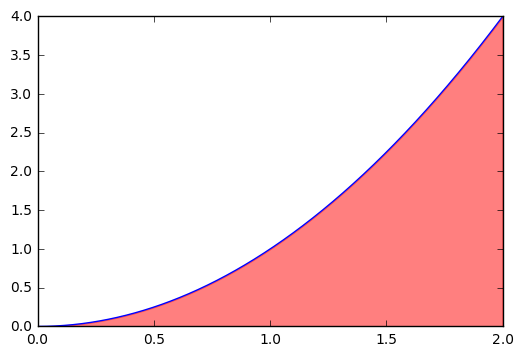

In [54]:
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(0,2,1000)
y = x **2
plt.plot(x,y)
plt.fill_between(x,y,where=(y >0),color='red',alpha=0.5)
plt.show()

[1 2]
[0.22313016014842982, 0.049787068367863944]
[ 0.81757448  0.18242552]


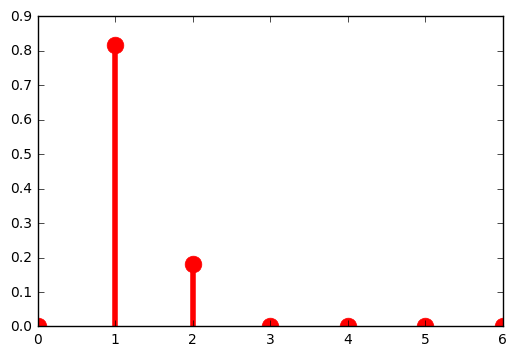

In [61]:
from scipy import stats
# exponential generator
alpha = 1.5
xk2 = np.arange(1,3,1)
print xk2
pk2 = [np.exp(-1*alpha*xi) for xi in xk2]
print pk2
pk2 = pk2/sum(pk2)
print pk2
pran_exp_gen = stats.rv_discrete(name='pran_exp_gen', values=(xk2, pk2))

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
ax.plot(xk, pran_exp_gen.pmf(xk), 'ro', ms=12, mec='r')
ax.vlines(xk, 0, pran_exp_gen.pmf(xk), colors='r', lw=4)
plt.show()

In [10]:
import json
import random
seedN = 10
dataset = "fdu2013"
datapath = "F:\\master\\mywork\\18familiarStrangers\\data\\"
seeds_Net1 = [str(int(x)) for x in json.load(open(datapath+"%s\\spreading para\\seeds_Net1.json"%dataset))]
print seeds_Net1
seeds = [str(int(x)) for x in random.sample(list(set(seeds_Net1)), seedN)]
print "The selected seeds is",seeds
for seed in seeds:
    if seed not in seeds_Net1:
         print "error!"

['35230', '10295', '6723', '29212', '15188', '21765', '18950', '1942', '26574', '8868', '32834', '33744', '816', '32654', '32302', '6849', '3335', '30516', '30511', '23840', '4738', '30550', '33633', '27274', '291', '21848', '198', '18179', '8600', '30679', '584', '32158', '19970', '26680', '17386', '3677', '2540', '7631', '5418', '18085', '29529', '2260', '2440', '31557', '9153', '9259', '10701', '20624', '15407', '38777', '12240', '245', '1848', '6278', '1242', '644', '6071', '649', '430', '9730', '14033', '2611', '19183', '20952', '11228', '17720', '30975', '853', '3510', '7260', '31689', '7415', '24455', '31396', '36921', '32618', '30480', '28866', '28860', '10242', '32584', '31890', '1623', '10091', '10095', '10848', '21257', '27132', '32270', '32054', '17610', '12055', '22752', '32350', '2941', '23936', '1051', '1057', '2348', '30157', '30528', '1758', '1175', '6972', '23507', '29588', '8799', '26653', '18022', '39359', '7821', '25570', '4460', '29663', '2124', '2127', '2126', '2

[0 1 2 3 4 5 6 7 8 9] [  1.00000000e+00   3.67879441e-01   1.35335283e-01   4.97870684e-02
   1.83156389e-02   6.73794700e-03   2.47875218e-03   9.11881966e-04
   3.35462628e-04   1.23409804e-04] [ 0.22592354  0.85181891  0.82765503  0.35170335  0.26509629  0.12738847
  0.9879361   0.8353431   0.8993916   0.51367933] [ 0.11438483  0.05258034  0.3305821   0.92033043  0.94758184  0.84116387
  0.15867914  0.41992317  0.24624292  0.20534977]


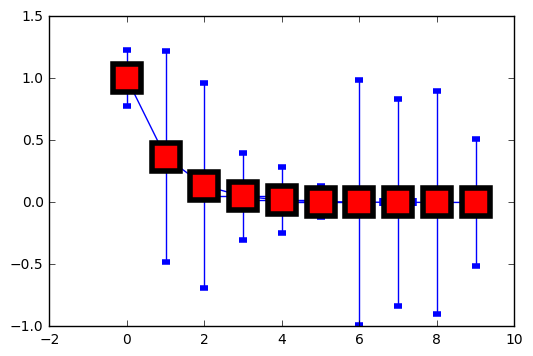

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import random

x = np.arange(10)
y = np.exp(-x)
xerr,yerr = np.random.rand(2,10)
print x,y,xerr,yerr
plt.errorbar(x, y,xerr, yerr, marker='s',
               mfc='red',mfcalt='black', mec='black', ms=20, mew=4)
# plt.errorbar(x, y, xerr=0, yerr=0.4)
plt.show()   

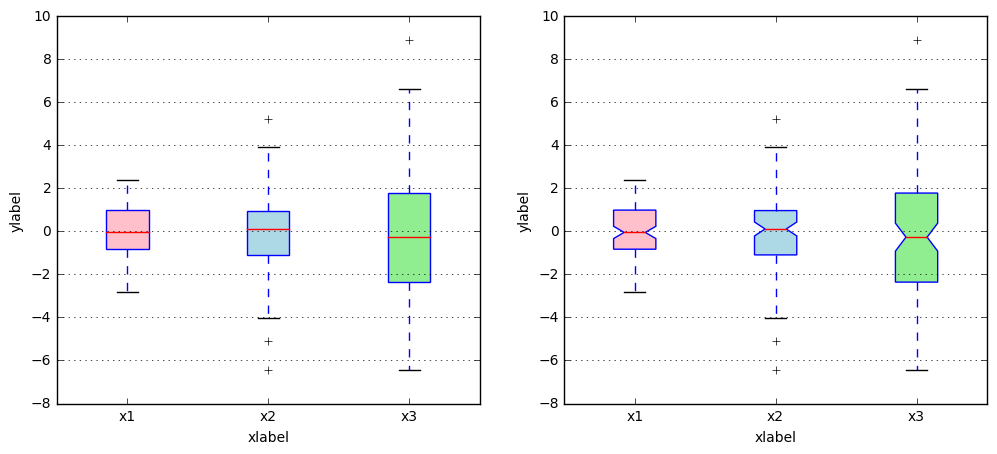

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Random test data
np.random.seed(123)
all_data = [np.random.normal(0, std, 100) for std in range(1, 4)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# rectangular box plot
bplot1 = axes[0].boxplot(all_data,
                         vert=True,   # vertical box aligmnent
                         patch_artist=True)   # fill with color

# notch shape box plot
bplot2 = axes[1].boxplot(all_data,
                         notch=True,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True)   # fill with color

# fill with colors
colors = ['pink', 'lightblue', 'lightgreen']
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

# adding horizontal grid lines
for ax in axes:
    ax.yaxis.grid(True)
    ax.set_xticks([y+1 for y in range(len(all_data))], )
    ax.set_xlabel('xlabel')
    ax.set_ylabel('ylabel')

# add x-tick labels
plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
         xticklabels=['x1', 'x2', 'x3', 'x4'])

plt.show()